# Линейная регрессия и основные библиотеки Python для анализа данных и научных вычислений

Это задание посвящено линейной регрессии. На примере прогнозирования роста человека по его весу Вы увидите, какая математика за этим стоит, а заодно познакомитесь с основными библиотеками Python, необходимыми для дальнейшего прохождения курса.

**Материалы**

- Лекции данного курса по линейным моделям и градиентному спуску
- [Документация](http://docs.scipy.org/doc/) по библиотекам NumPy и SciPy
- [Документация](http://matplotlib.org/) по библиотеке Matplotlib 
- [Документация](http://pandas.pydata.org/pandas-docs/stable/tutorials.html) по библиотеке Pandas
- [Pandas Cheat Sheet](http://www.analyticsvidhya.com/blog/2015/07/11-steps-perform-data-analysis-pandas-python/)
- [Документация](http://stanford.edu/~mwaskom/software/seaborn/) по библиотеке Seaborn 

## Задание 1. Первичный анализ данных c Pandas

В этом заданиии мы будем использовать данные [SOCR](http://wiki.stat.ucla.edu/socr/index.php/SOCR_Data_Dinov_020108_HeightsWeights) по росту и весу 25 тысяч подростков.

**[1].** Если у Вас не установлена библиотека Seaborn - выполните в терминале команду *conda install seaborn*. (Seaborn не входит в сборку Anaconda, но эта библиотека предоставляет удобную высокоуровневую функциональность для визуализации данных).

In [52]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.optimize
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize
%matplotlib inline

Считаем данные по росту и весу (*weights_heights.csv*, приложенный в задании) в объект Pandas DataFrame:

In [2]:
data = pd.read_csv('weights_heights.csv', index_col='Index')

Чаще всего первое, что надо надо сделать после считывания данных - это посмотреть на первые несколько записей. Так можно отловить ошибки чтения данных (например, если вместо 10 столбцов получился один, в названии которого 9 точек с запятой). Также это позволяет познакомиться с данными, как минимум, посмотреть на признаки и их природу (количественный, категориальный и т.д.). 

После этого стоит построить гистограммы распределения признаков - это опять-таки позволяет понять природу признака (степенное у него распределение, или нормальное, или какое-то еще). Также благодаря гистограмме можно найти какие-то значения, сильно не похожие на другие - "выбросы" в данных. 
Гистограммы удобно строить методом *plot* Pandas DataFrame с аргументом *kind='hist'*.

**Пример.** Построим гистограмму распределения роста подростков из выборки *data*. Используем метод *plot* для DataFrame *data* c аргументами *y='Height'* (это тот признак, распределение которого мы строим)

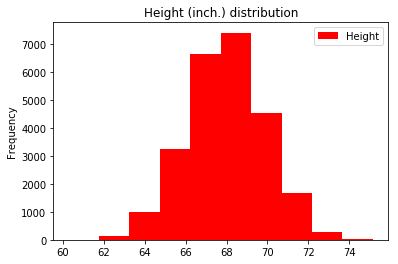

In [3]:
data.plot(y='Height', kind='hist', 
           color='red',  title='Height (inch.) distribution')

Аргументы:

- *y='Height'* - тот признак, распределение которого мы строим
- *kind='hist'* - означает, что строится гистограмма
- *color='red'* - цвет

**[2]**. Посмотрите на первые 5 записей с помощью метода *head* Pandas DataFrame. Нарисуйте гистограмму распределения веса с помощью метода *plot* Pandas DataFrame. Сделайте гистограмму зеленой, подпишите картинку.

In [4]:
data.head(5)

,Height,Weight
Index,,
1,65.78331,112.9925
2,71.51521,136.4873
3,69.39874,153.0269
4,68.21660,142.3354
5,67.78781,144.2971


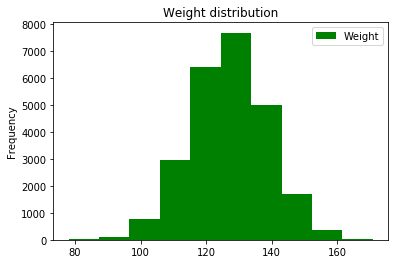

In [5]:
data.plot(y='Weight', kind='hist', 
           color='green',  title='Weight distribution')

Один из эффективных методов первичного анализа данных - отображение попарных зависимостей признаков. Создается $m \times m$ графиков (*m* - число признаков), где по диагонали рисуются гистограммы распределения признаков, а вне диагонали - scatter plots зависимости двух признаков. Это можно делать с помощью метода $scatter\_matrix$ Pandas Data Frame или *pairplot* библиотеки Seaborn. 

Чтобы проиллюстрировать этот метод, интересней добавить третий признак. Создадим признак *Индекс массы тела* ([BMI](https://en.wikipedia.org/wiki/Body_mass_index)). Для этого воспользуемся удобной связкой метода *apply* Pandas DataFrame и lambda-функций Python.

In [6]:
def make_bmi(height_inch, weight_pound):
    METER_TO_INCH, KILO_TO_POUND = 39.37, 2.20462
    return (weight_pound / KILO_TO_POUND) / \
           (height_inch / METER_TO_INCH) ** 2

In [7]:
data['BMI'] = data.apply(lambda row: make_bmi(row['Height'], 
                                              row['Weight']), axis=1)

**[3].** Постройте картинку, на которой будут отображены попарные зависимости признаков , 'Height', 'Weight' и 'BMI' друг от друга. Используйте метод *pairplot* библиотеки Seaborn.

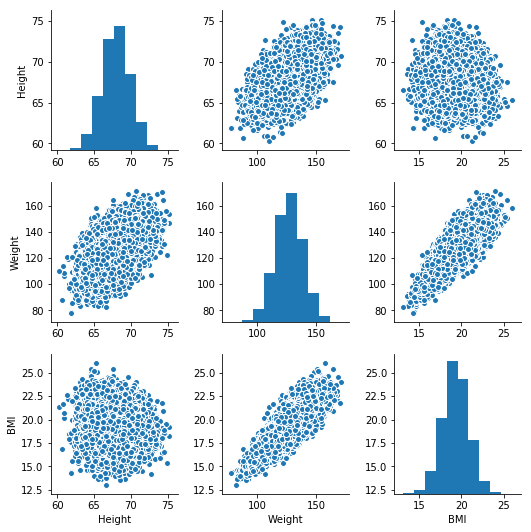

In [8]:
dependencies = [ 'Height', 'Weight', 'BMI']
sns.pairplot(data[dependencies])

Часто при первичном анализе данных надо исследовать зависимость какого-то количественного признака от категориального (скажем, зарплаты от пола сотрудника). В этом помогут "ящики с усами" - boxplots библиотеки Seaborn. Box plot - это компактный способ показать статистики вещественного признака (среднее и квартили) по разным значениям категориального признака. Также помогает отслеживать "выбросы" - наблюдения, в которых значение данного вещественного признака сильно отличается от других. 

**[4]**. Создайте в DataFrame *data* новый признак *weight_category*, который будет иметь 3 значения: 1 – если вес меньше 120 фунтов. (~ 54 кг.), 3 - если вес  больше или равен 150 фунтов (~68 кг.), 2 – в остальных случаях. Постройте «ящик с усами» (boxplot), демонстрирующий зависимость роста от весовой категории. Используйте метод *boxplot* библиотеки Seaborn и метод *apply* Pandas DataFrame. Подпишите ось *y* меткой «Рост», ось *x* – меткой «Весовая категория».

Text(0.5,0,'Весовая категория')

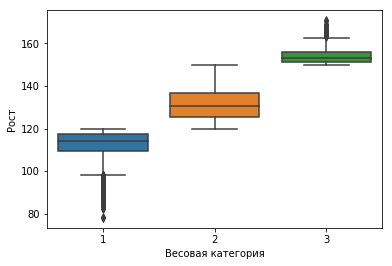

In [9]:
def weight_category(weight):
    if (weight < 120):
        return 1
    elif (weight >= 150):
        return 3
    else:
        return 2

data['weight_cat'] = data['Weight'].apply(weight_category)
boxplot = sns.boxplot(y = 'Weight', x = 'weight_cat', data = data)
boxplot.set_ylabel('Рост')
boxplot.set_xlabel('Весовая категория')

**[5].** Постройте scatter plot зависимости роста от веса, используя метод *plot* для Pandas DataFrame с аргументом *kind='scatter'*. Подпишите картинку.

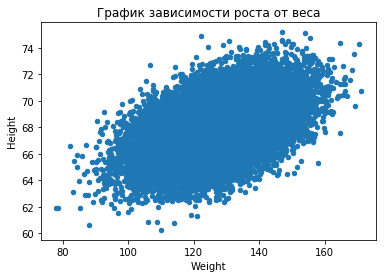

In [10]:
data.plot(y = 'Height', x = 'Weight', kind = 'scatter', title = 'График зависимости роста от веса')

## Задание 2. Минимизация квадратичной ошибки

В простейшей постановке задача прогноза значения вещественного признака по прочим признакам (задача восстановления регрессии) решается минимизацией квадратичной функции ошибки. 

**[6].** Напишите функцию, которая по двум параметрам $w_0$ и $w_1$ вычисляет квадратичную ошибку приближения зависимости роста $y$ от веса $x$ прямой линией $y = w_0 + w_1 * x$:
$$error(w_0, w_1) = \sum_{i=1}^n {(y_i - (w_0 + w_1 * x_i))}^2 $$
Здесь $n$ – число наблюдений в наборе данных, $y_i$ и $x_i$ – рост и вес $i$-ого человека в наборе данных. 

In [11]:
def error(w0, w1):
    result = 0
    for index, row in data.iterrows():
        result += (row['Height'] - (w0 + w1 * row['Weight'])) ** 2
    return result

Итак, мы решаем задачу: как через облако точек, соответсвующих наблюдениям в нашем наборе данных, в пространстве признаков "Рост" и "Вес" провести прямую линию так, чтобы минимизировать функционал из п. 6. Для начала давайте отобразим хоть какие-то прямые и убедимся, что они плохо передают зависимость роста от веса.

**[7].** Проведите на графике из п. 5 Задания 1 две прямые, соответствующие значениям параметров ($w_0, w_1) = (60, 0.05)$ и ($w_0, w_1) = (50, 0.16)$. Используйте метод *plot* из *matplotlib.pyplot*, а также метод *linspace* библиотеки NumPy. Подпишите оси и график.

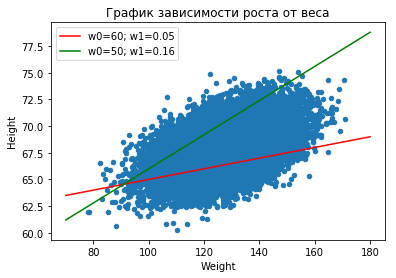

In [24]:
def lineY(w0, w1):
    y = []
    for i in x:
        y.append(w0 + w1 * i)
    return y

data.plot(y = 'Height', x = 'Weight', kind = 'scatter', title = 'График зависимости роста от веса')
x = np.linspace(70, 180)
y1 = lineY(60, 0.05)
y2 = lineY(50, 0.16)
plt.plot(x, y1, color='red')
plt.plot(x, y2, color='green')
plt.legend( ('w0=60; w1=0.05', 'w0=50; w1=0.16') )

Минимизация квадратичной функции ошибки - относительная простая задача, поскольку функция выпуклая. Для такой задачи существует много методов оптимизации. Посмотрим, как функция ошибки зависит от одного параметра (наклон прямой), если второй параметр (свободный член) зафиксировать.

**[8].** Постройте график зависимости функции ошибки, посчитанной в п. 6, от параметра $w_1$ при $w_0$ = 50. Подпишите оси и график.

Text(0.5,1,'Зависимость ошибки от w1 при w0=50')

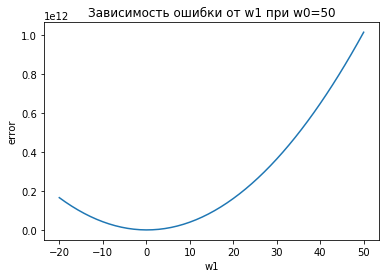

In [41]:
x = np.linspace(-20, 50)
y = []
for w1 in x:
    y.append(error(50, w1))
plt.plot(x, y)
plt.xlabel('w1')
plt.ylabel('error')
plt.title('Зависимость ошибки от w1 при w0=50')

Теперь методом оптимизации найдем "оптимальный" наклон прямой, приближающей зависимость роста от веса, при фиксированном коэффициенте $w_0 = 50$.

**[9].** С помощью метода *minimize_scalar* из *scipy.optimize* найдите минимум функции, определенной в п. 6, для значений параметра  $w_1$ в диапазоне [-5,5]. Проведите на графике из п. 5 Задания 1 прямую, соответствующую значениям параметров ($w_0$, $w_1$) = (50, $w_1\_opt$), где $w_1\_opt$ – найденное в п. 8 оптимальное значение параметра $w_1$. 

In [42]:
w1_opt = minimize_scalar(lambda w1: error(50, w1), bounds=(-5, 5))
w1_opt.x

0.14109203728834385

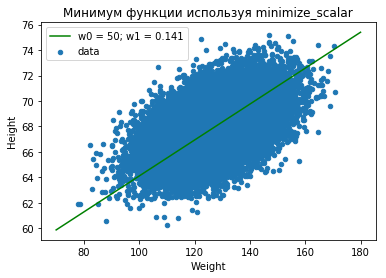

In [97]:
data.plot(y = 'Height', x = 'Weight', kind = 'scatter', title = 'Минимум функции используя minimize_scalar')
x = np.linspace(70, 180)
y = []
for i in x:
    y.append(50 + w1_opt.x * i)
plt.plot(x, y, color = 'green')
plt.legend( ('w0 = 50; w1 = 0.141', 'data') )

При анализе многомерных данных человек часто хочет получить интуитивное представление о природе данных с помощью визуализации. Увы, при числе признаков больше 3 такие картинки нарисовать невозможно. На практике для визуализации данных в 2D и 3D в данных выделаяют 2 или, соответственно, 3 главные компоненты (как именно это делается - мы увидим далее в курсе) и отображают данные на плоскости или в объеме. 

Посмотрим, как в Python рисовать 3D картинки, на примере отображения функции $z(x,y) = sin(\sqrt{x^2+y^2})$ для значений $x$ и $y$ из интервала [-5,5] c шагом 0.25.

In [44]:
from mpl_toolkits.mplot3d import Axes3D

Создаем объекты типа matplotlib.figure.Figure (рисунок) и  matplotlib.axes._subplots.Axes3DSubplot (ось). 

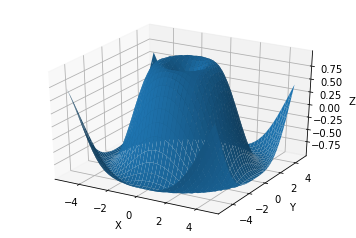

In [45]:
fig = plt.figure()
ax = fig.gca(projection='3d') # get current axis

# Создаем массивы NumPy с координатами точек по осям X и У. 
# Используем метод meshgrid, при котором по векторам координат 
# создается матрица координат. Задаем нужную функцию Z(x, y).
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
Z = np.sin(np.sqrt(X**2 + Y**2))

# Наконец, используем метод *plot_surface* объекта 
# типа Axes3DSubplot. Также подписываем оси.
surf = ax.plot_surface(X, Y, Z)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

**[10].** Постройте 3D-график зависимости функции ошибки, посчитанной в п.6 от параметров $w_0$ и $w_1$. Подпишите ось $x$ меткой «Intercept», ось $y$ – меткой «Slope», a ось $z$ – меткой «Error».

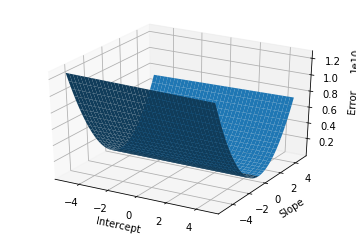

In [50]:
fig = plt.figure()
ax = fig.gca(projection='3d')
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
Z = error(X, Y)

surf = ax.plot_surface(X, Y, Z)
ax.set_xlabel('Intercept')
ax.set_ylabel('Slope')
ax.set_zlabel('Error')
plt.show()

In [19]:
# Ваш код здесь

In [20]:
# Ваш код здесь

**[11].** С помощью метода *minimize* из scipy.optimize найдите минимум функции, определенной в п. 6, для значений параметра $w_0$ в диапазоне [-100,100] и $w_1$ - в диапазоне [-5, 5]. Начальная точка – ($w_0$, $w_1$) = (0, 0). Используйте метод оптимизации L-BFGS-B (аргумент method метода minimize). Проведите на графике из п. 5 Задания 1 прямую, соответствующую найденным оптимальным значениям параметров $w_0$ и $w_1$. Подпишите оси и график.

In [56]:
minFunction = minimize(lambda w: error(w[0], w[1]), [0, 0], method='L-BFGS-B', bounds=([-100, 100], [-5, 5]))
minFunction

      fun: 67545.287085290838
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.04802132, -0.93132257])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 51
      nit: 12
   status: 0
  success: True
        x: array([ 57.57171454,   0.08200697])

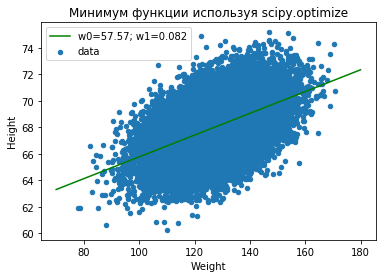

In [100]:
data.plot(y = 'Height', x = 'Weight', kind = 'scatter', title = 'Минимум функции используя scipy.optimize')
x = np.linspace(70, 180)
y = []
for i in x:
    y.append(minFunction.x[0] + minFunction.x[1] * i)
plt.plot(x, y, color = 'green')
plt.legend(('w0=57.57; w1=0.082', 'data'))

## Критерии оценки работы

- Выполняется ли тетрадка IPython без ошибок? (15 баллов)
- Верно ли отображена гистограмма распределения роста из п. 2? (3 балла). Правильно ли оформлены подписи? (1 балл)
- Верно ли отображены попарные зависимости признаков из п. 3? (3 балла). Правильно ли оформлены подписи? (1 балл)
- Верно ли отображена зависимость роста от весовой категории из п. 4? (3 балла). Правильно ли оформлены подписи? (1 балл)
- Верно ли отображен scatter plot роста от веса из п. 5? (3 балла). Правильно ли оформлены подписи? (1 балл)
- Правильно ли реализована функция подсчета квадратичной ошибки из п. 6? (10 баллов)
- Правильно ли нарисован график из п. 7? (3 балла) Правильно ли оформлены подписи? (1 балл)
- Правильно ли нарисован график из п. 8? (3 балла) Правильно ли оформлены подписи? (1 балл)
- Правильно ли используется метод minimize\_scalar из scipy.optimize? (6 баллов). Правильно ли нарисован график из п. 9? (3 балла) Правильно ли оформлены подписи? (1 балл)
- Правильно ли нарисован 3D-график из п. 10? (6 баллов) Правильно ли оформлены подписи? (1 балл)
- Правильно ли используется метод minimize из scipy.optimize? (6 баллов). Правильно ли нарисован график из п. 11? (3 балла). Правильно ли оформлены подписи? (1 балл)